### **Load Library**

In [ ]:
from google.colab import drive

# Mount Google-Drive Directory
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
import os
import kagglehub
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
from google.colab import userdata
from matplotlib import pyplot as plt

In [ ]:
FOLDER_PATH = "/content/gdrive/MyDrive/AI Models/SupervisedLearning/regression-crop-yield"
%cd $FOLDER_PATH

/content/gdrive/MyDrive/AI Models/SupervisedLearning/regression-crop-yield


### **Load Dataset**

In [ ]:
# Load data from kaggle
def pandas_df(path: str, file_name: str) -> pd.DataFrame:

    path = os.path.join(path, f"{file_name}")

    return pd.read_csv(path)


In [ ]:
# https://www.kaggle.com/datasets/samuelotiattakorah/agriculture-crop-yield

PATH = kagglehub.dataset_download("samuelotiattakorah/agriculture-crop-yield")
df = pandas_df(PATH, 'crop_yield.csv')
df.columns = [c.lower() for c in df.columns]
df.head()

,region,soil_type,crop,rainfall_mm,temperature_celsius,fertilizer_used,irrigation_used,weather_condition,days_to_harvest,yield_tons_per_hectare
0,West,Sandy,Cotton,897.077239,27.676966,False,True,Cloudy,122,6.555816
1,South,Clay,Rice,992.673282,18.026142,True,True,Rainy,140,8.527341
2,North,Loam,Barley,147.998025,29.794042,False,False,Sunny,106,1.127443
3,North,Sandy,Soybean,986.866331,16.644190,False,True,Rainy,146,6.517573
4,South,Silt,Wheat,730.379174,31.620687,True,True,Cloudy,110,7.248251


#### **Feature Importance**

#### **Model Development**

In [ ]:
from sklearn.model_selection import train_test_split

feature_data_pd = df.copy()
print(f"We have {feature_data_pd.shape[0]} records in our source dataset")

# split target variable into it's own dataset
target_col = "crop_yield"
X_all = feature_data_pd.drop(labels=target_col, axis=1)
y_all = feature_data_pd[target_col]

# test / train split
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, train_size=0.8, random_state=42)
print(f"We have {X_train.shape[0]} records in our training dataset")
print(f"We have {X_test.shape[0]} records in our test dataset")

We have 1000000 records in our source dataset
We have 800000 records in our training dataset
We have 200000 records in our test dataset


In [ ]:
from math import sqrt
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_percentage_error

# Apply the Standard Scaler to all our numerical features
columns_scaler = ["rainfall_mm", "temperature_celsius", "days_to_harvest"]
columns_encoder = list(set(X_train.columns) - set(columns_scaler))

std_ct = make_column_transformer(
    (StandardScaler(), columns_scaler), remainder="passthrough"
)

In [ ]:
# pipeline to transform inputs and then pass results to the linear regression model
lr_pl = Pipeline(steps=[
  ("tx_inputs", std_ct),
  ("lr", LinearRegression() )
])

# fit our model
lr_mdl = lr_pl.fit(X_train, y_train)

In [ ]:
# evaluate the test set
predicted = lr_mdl.predict(X_test)
test_r2 = r2_score(y_test, predicted)
test_mse = mean_squared_error(y_test, predicted)
test_rmse = sqrt(test_mse)
test_mape = mean_absolute_percentage_error(y_test, predicted)

print("Test evaluation summary:")
print(f"R^2: {test_r2}")
print(f"MSE: {test_mse}")
print(f"RMSE: {test_rmse}")
print(f"MAPE: {test_mape}")

Test evaluation summary:
R^2: 0.9131697029900037
MSE: 0.25032712469652163
RMSE: 0.5003270177559089
MAPE: 0.1208340860285384


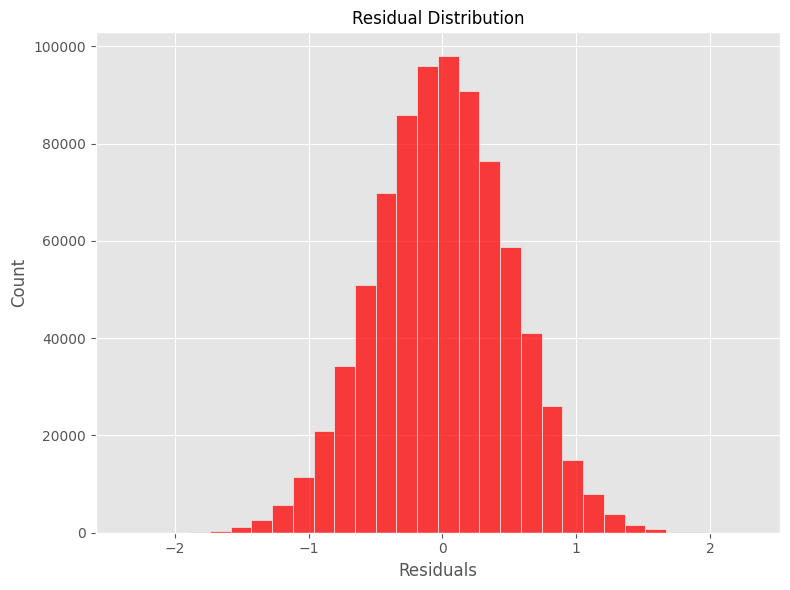

In [ ]:
# Calculating model errors (residuals)
resid = pd.DataFrame(np.transpose([y_train - lr_mdl.predict(X_train)]), columns=["Training Error"])

# Plot model errors
plt.subplots(1,1, figsize=(8, 6))
plt.style.use("ggplot")

sns.histplot(data=resid, x="Training Error", color="red", bins=30)

plt.xlabel("Residuals")
plt.ylabel("Count")
plt.title("Residual Distribution", fontdict={"fontsize": 12, "fontweight": "light"})
plt.tight_layout()
plt.show()

In [ ]:
from scipy import stats

# Extracting coefficients and intercept
coefficients = np.append([lr_mdl.named_steps['lr'].intercept_], lr_mdl.named_steps['lr'].coef_)
coefficient_names = ['Intercept'] + X_train.columns.to_list()

# Calculating standard errors and other statistics
n_rows, n_cols = X_train.shape
X_with_intercept = np.append(np.ones((n_rows, 1)), X_train, axis=1)
var_b = test_mse * np.linalg.inv(np.dot(X_with_intercept.T, X_with_intercept)).diagonal()
standard_errors = np.sqrt(var_b)
t_values = coefficients / standard_errors
p_values = [2 * (1 - stats.t.cdf(np.abs(i), (len(X_with_intercept) - 1))) for i in t_values]

# Creating a DataFrame for display
summary_df = pd.DataFrame({'Coefficient': coefficients,
                           'Standard Error': standard_errors,
                           't-value': t_values,
                           'p-value': p_values},
                          index=coefficient_names)

# Print the DataFrame
print(summary_df)

                     Coefficient  Standard Error       t-value   p-value
Intercept               3.173829        0.037452     84.744783  0.000000
weather_condition       1.297638        0.000685   1893.819808  0.000000
crop_type               0.143732        0.000327    438.947297  0.000000
irrigation_used         0.000518        0.001119      0.463224  0.643204
days_to_harvest        -0.000093        0.000022     -4.318792  0.000016
rainfall_mm            -0.000597        0.000002   -276.982289  0.000000
temperature_celsius    -1.198624        0.000077 -15469.568541  0.000000
crop_yield_success      1.328368        0.037317     35.596410  0.000000
fertilizer_used         1.498800        0.001119   1339.527954  0.000000
region                  0.000324        0.000500      0.647370  0.517393
soil_type              -0.000698        0.000327     -2.132797  0.032942


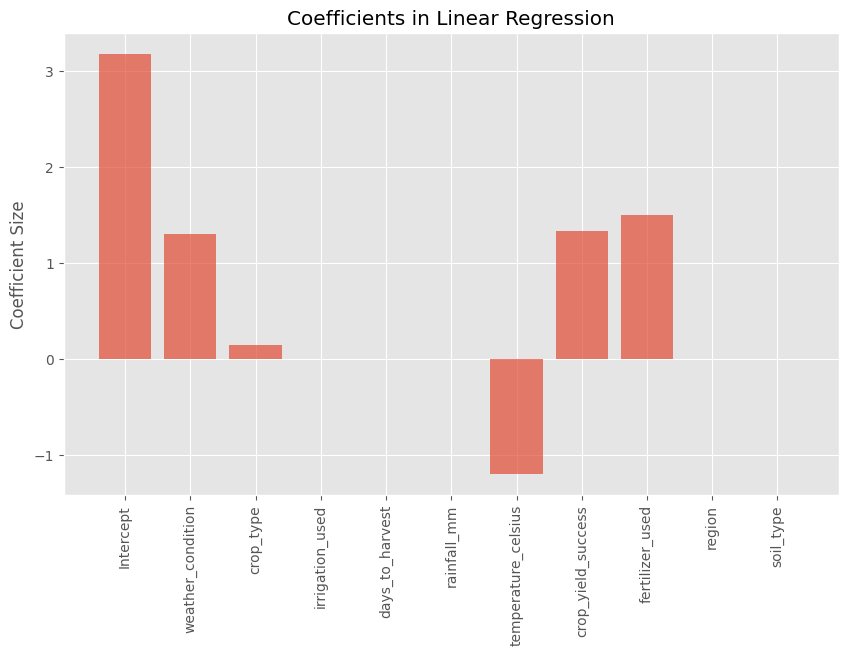

In [ ]:
# Plotting the feature importances
plt.figure(figsize=(10, 6))
y_pos = np.arange(len(coefficient_names))
plt.bar(y_pos, coefficients, align='center', alpha=0.7)
plt.xticks(y_pos, coefficient_names, rotation=90)
plt.ylabel('Coefficient Size')
plt.title('Coefficients in Linear Regression')

plt.show()

**Note:** Try to go learn about interpreting the model information provided above.